In [1]:
%load_ext autoreload
%autoreload 2
from transformer import SpeechTransformer
import os
import torch
import numpy as np
from torch.utils.data import DataLoader
from custom_dataset import SpectrogramDataset, BinaryDataset, create_sampler
from training_pipeline import repeat_training, set_seed, worker_init_fn, plot_results
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Training with default settings

In [2]:
SEED = 42
set_seed(SEED)
repetitions = 4
lr = 0.001
epochs = 100
tolerance = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# default settings
alpha = 1
dropout = 0.3
weight_decay = 0.0
augmented_fraction = 0.3
label_smoothing = 0.0

batch_size = 256
n_workers = 4
prefetch_factor = 2 if n_workers > 0 else None
persistent_workers = True if n_workers > 0 else False

In [3]:
data_path = "data/train/audio_transformed"
train_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TRAIN, augmentation=True, augmented_fraction=augmented_fraction)
val_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.VAL)
test_dataset = SpectrogramDataset(data_path, set_type=SpectrogramDataset.TEST)

sampler = create_sampler(train_dataset, alpha)
train_loader = DataLoader(train_dataset, sampler=sampler, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor,persistent_workers=persistent_workers, worker_init_fn=worker_init_fn)

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=persistent_workers)

## model dim

In [4]:
# d_model = 128
nhead = 4
num_layers = 4

set_seed(SEED)

d_model_list = [64, 128, 256]
for d_model in d_model_list:
     
     def init_transformer():
          return SpeechTransformer(num_classes=11, dropout=dropout, d_model=d_model, nhead=nhead, num_layers=num_layers)
     
     model_dir = f"output/models/all_classes/transformer/d_model/d_model={d_model}"
     history_dir = f"output/history/all_classes/transformer/d_model/d_model={d_model}"
     
     os.makedirs(model_dir, exist_ok=True)
     os.makedirs(history_dir, exist_ok=True)
     
     model_path = model_dir + "/transformer.pth"
     history_path = history_dir + "/transformer.pkl"
     
     repeat_training(repetitions, init_transformer, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance, weight_decay=weight_decay, label_smoothing=label_smoothing)

training iteration: 1 of 4
starting training...
epoch: 1, training loss: 0.009359494010333615, training accuracy: 11.323598496711556, training balanced accuracy: 11.267594236561047
epoch: 1, validation loss: 0.009964965974348157, validation accuracy: 6.104736687260959, validation balanced accuracy: 14.547660319027637
model saved

epoch: 2, training loss: 0.008921942473241911, training accuracy: 17.0783745693705, training balanced accuracy: 17.018541944232442
epoch: 2, validation loss: 0.010008496724706988, validation accuracy: 6.501912327155045, validation balanced accuracy: 15.66514221146721

epoch: 3, training loss: 0.008587340870099198, training accuracy: 20.691747572815533, training balanced accuracy: 20.645532607461643
epoch: 3, validation loss: 0.009925367534774372, validation accuracy: 9.355692850838482, validation balanced accuracy: 21.88383648870074
model saved

epoch: 4, training loss: 0.007957547751389214, training accuracy: 27.11595678045725, training balanced accuracy: 27.

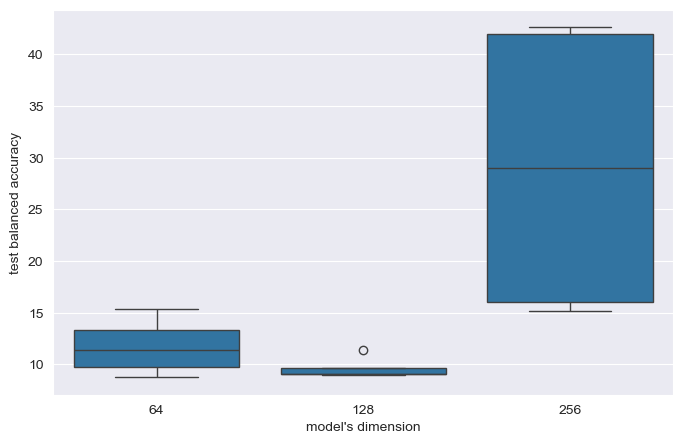

In [5]:
d_model_root_dir = "output/history/all_classes/transformer/d_model"
d_model_list = [64, 128, 256]
x_label = "model's dimension"
plot_results(d_model_root_dir, d_model_list, x_label, use_balanced_accuracy=True)

## number of heads

In [8]:
d_model = 256 # None # optimal or 128 
num_layers = 4

set_seed(SEED)

nhead_list = [2, 4, 8]
for nhead in nhead_list:
     
     def init_transformer():
          return SpeechTransformer(num_classes=11, dropout=dropout, d_model=d_model, nhead=nhead, num_layers=num_layers)
     
     model_dir = f"output/models/all_classes/transformer/nhead/nhead={nhead}"
     history_dir = f"output/history/all_classes/transformer/nhead/nhead={nhead}"
     
     os.makedirs(model_dir, exist_ok=True)
     os.makedirs(history_dir, exist_ok=True)
     
     model_path = model_dir + "/transformer.pth"
     history_path = history_dir + "/transformer.pkl"
     
     repeat_training(repetitions, init_transformer, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance, weight_decay=weight_decay, label_smoothing=label_smoothing)

training iteration: 1 of 4
starting training...
epoch: 1, training loss: 0.009516269178589123, training accuracy: 9.129345443156906, training balanced accuracy: 9.081349123597137
epoch: 1, validation loss: 0.009017076587705059, validation accuracy: 3.8393645189761694, validation balanced accuracy: 9.090909090909092
model saved

epoch: 2, training loss: 0.009430058377497703, training accuracy: 8.812245537112434, training balanced accuracy: 8.7988005460403
epoch: 2, validation loss: 0.009932686771214377, validation accuracy: 3.824654310091203, validation balanced accuracy: 9.090909090909092

epoch: 3, training loss: 0.009413190137022086, training accuracy: 9.086282492953336, training balanced accuracy: 9.073646090160366
epoch: 3, validation loss: 0.009104043113796036, validation accuracy: 3.824654310091203, validation balanced accuracy: 9.090909090909092

epoch: 4, training loss: 0.009409513419002266, training accuracy: 9.342702787347323, training balanced accuracy: 9.316071468953488
epo

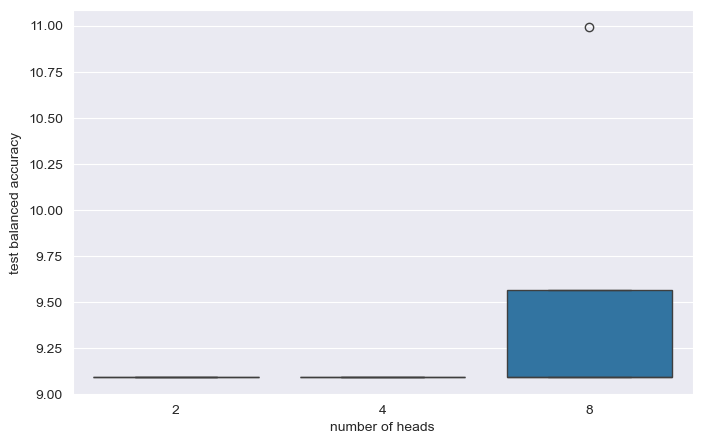

In [9]:
nhead_root_dir = "output/history/all_classes/transformer/nhead"
nhead_list = [2, 4, 8]
x_label = "number of heads"
plot_results(nhead_root_dir, nhead_list, x_label, use_balanced_accuracy=True)

## number of layers

In [10]:
d_model = 256 # None # optimal or 128
nhead = 8 # = None # optimal or 4

set_seed(SEED)

num_layers_list = [2, 4, 8]
for num_layers in num_layers_list:
     
     def init_transformer():
          return SpeechTransformer(num_classes=11, dropout=dropout, d_model=d_model, nhead=nhead, num_layers=num_layers)
     
     model_dir = f"output/models/all_classes/transformer/num_layers/num_layers={num_layers}"
     history_dir = f"output/history/all_classes/transformer/num_layers/num_layers={num_layers}"
     
     os.makedirs(model_dir, exist_ok=True)
     os.makedirs(history_dir, exist_ok=True)
     
     model_path = model_dir + "/transformer.pth"
     history_path = history_dir + "/transformer.pkl"
     
     repeat_training(repetitions, init_transformer, lr, model_path, history_path, epochs, train_loader, val_loader, test_loader, device, tolerance=tolerance, weight_decay=weight_decay, label_smoothing=label_smoothing)

training iteration: 1 of 4
starting training...
epoch: 1, training loss: 0.009105291914088652, training accuracy: 15.835421233949264, training balanced accuracy: 15.804423836344753
epoch: 1, validation loss: 0.008996714210117449, validation accuracy: 9.120329508679022, validation balanced accuracy: 20.008659324323332
model saved

epoch: 2, training loss: 0.008262593335318334, training accuracy: 24.011509552145316, training balanced accuracy: 23.944905906422626
epoch: 2, validation loss: 0.009730174931472595, validation accuracy: 14.31303324507208, validation balanced accuracy: 31.682929264408916

epoch: 3, training loss: 0.00724205980471149, training accuracy: 35.29987472596304, training balanced accuracy: 35.27596880045482
epoch: 3, validation loss: 0.008049764714545452, validation accuracy: 25.16916740217711, validation balanced accuracy: 39.56949534619753
model saved

epoch: 4, training loss: 0.006436726169977448, training accuracy: 43.51902599436267, training balanced accuracy: 43.

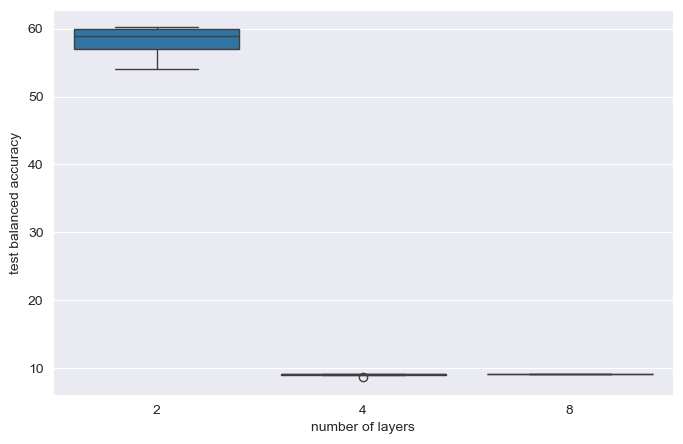

In [11]:
num_layers_root_dir = "output/history/all_classes/transformer/num_layers"
num_layers_list = [2, 4, 8]
x_label = "number of layers"
plot_results(num_layers_root_dir, num_layers_list, x_label, use_balanced_accuracy=True)

In [ ]:
# results
d_model = 256
nhead = 8
num_layers = 2